# Titanic: Machine Learning from Disaster


In [4]:
# Importar módulos base - matplotlib for plotting, numpy and pandas

import numpy as np
import pandas as pd
%matplotlib inline

# Carregar arquivo de treino
train_dataset = pd.read_csv('./data/titanic/train.csv')
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Carregar arquivo de teste
test_dataset = pd.read_csv('./data/titanic/test.csv')
test_dataset.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Exploratory Data Analysis


Este é o primeiro passo para compreender a qualidade dos dados. Neste momento vamos combinar os dados de teste e de treino antes de iniciar nossa análise exploratória. 

A fim de combinar os 2 conjuntos de dados, precisamos criar uma coluna adicional no teste chamada 'sobreviveu' e adicionar o valor -1, a fim de sermos capazes de distinguir posteriormente os dados de treino e teste. Também há uma necessidade de reorganizar as colunas nos dados de treino para refletir o posicionamento das colunas dos dados de teste.

In [6]:
test_dataset.is_copy = False
test_dataset['Survived']=-1
train_dataset = train_dataset[['PassengerId','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Survived']]
mergedTitanicDS = train_dataset.append(test_dataset)

## Find Missing Data

In [7]:
for col in mergedTitanicDS:
    if mergedTitanicDS[col].isnull().sum()>0:
        print("Missing Values in %s %d" % (col,(mergedTitanicDS[col].isnull().sum())))

Missing Values in Age 263
Missing Values in Fare 1
Missing Values in Cabin 1014
Missing Values in Embarked 2


Como resultado, vemos acima os seguintes valores missing nos dados de treino.

### Embarked

Vamos começar atacando os mais simples. **Embarked** tem 2 valores em falta. É um ponto de dados categóricos e tem a seguinte distribuição:

In [5]:
# Get the distribution of the Embarked
mergedTitanicDS['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

Temos pouca massa de manobra aqui. Uma estratégia consistente aqui poderia ser substituir os valores missing pelo valor de "S", já que o mesmo supera tanto "C" quanto "Q" em termos de númericos.

In [8]:
mergedTitanicDS.is_copy = False
mergedTitanicDS.loc[mergedTitanicDS['Embarked'].isnull(),'Embarked'] = 'S'

### Cabin

Vamos evoluir nossa análise. Olhando para o problemas dos dados missing na feature **cabin**, 

In [9]:
mergedTitanicDS['IsCabinDataEmpty'] = 0
mergedTitanicDS.loc[mergedTitanicDS['Cabin'].isnull(),'IsCabinDataEmpty'] = 1

In [8]:
# Extract the Title and assign it to the new column
mergedTitanicDS['Title'] = [nameStr[1].strip().split('.')[0] for nameStr in mergedTitanicDS['Name'].str.split(',')]

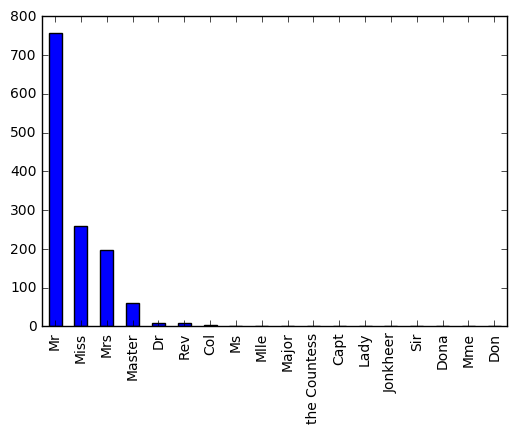

In [9]:
# The following plot shows the distribution of Titles
mergedTitanicDS['Title'].value_counts().plot.bar()

### Age

A idade é um ponto de dados contínuo. Há 177 valores missing, o que representa cerca de 19% dos dados. Existem várias estratégias para substituição da idade, o mais simples é substituir por uma **média**, **mediana** ou **moda**. 

A armadilha nesta estratégia é que todos os passageiros com a idade em falta terão o mesmo valor estático, o que pode resultar em uma criança com a idade de um adulto.

> Importante! Esta é a fase mais pesada, a fase onde devemos conhecer os nossos dados a fim de definir a melhor estratégia possível.

### Title

Outro ponto importante aqui, é que temos junto aos nomes os títulos de tratamento para cada pessoa. Sendo assim podemos agregar a nossa estratégia de idade a indução da mesma com base no título.

Neste caso vamos extrair o título do nome e encontrar a média entre idadade e o título informado, e depois substituir os valores missing. Essa estratégia serve para ajudar a evitar substituir o valor missing de uma possível criança pela idade de um adulto. Assim diminuímos a margem de erro no tratamento de dados missing.

Extrair e cruzar os dados de idade com os dados de título é um exemplo de **Feature Engineering**, que visa tornar o conjunto de dados mais rico para o aprendizado.

In [10]:
# Aggregate on Age by Title using mean
aggAgeByTitleDS = mergedTitanicDS[['Age','Title']].groupby(['Title']).mean().reset_index()

# Renaming the columns
aggAgeByTitleDS.columns = ['Title','Mean_Age']

# Merging by Title
mergedTitanicDS_Merged = pd.merge(mergedTitanicDS, aggAgeByTitleDS,on="Title")

# Replacing the missing values of Age by Mean Age
mergedTitanicDS_Merged.loc[mergedTitanicDS_Merged['Age'].isnull(),'Age']=mergedTitanicDS_Merged[mergedTitanicDS_Merged['Age'].isnull()]['Mean_Age']

### Fare

Há apenas um passageiro com dados missing sobre a tarifa. O passageiro em questão é senhor "Storey, Mr. Thomas". Se olharmos para os dados do senhor Thomas, veremos que ele viajou na classe Pclass 3. 

Neste caso podemos usar como estratégia, obter a média da tarifa paga pelos passageiros da classe Pclass 3.

In [11]:
# Applying the Fare for the missing values

mergedTitanicDS_Merged.loc[mergedTitanicDS_Merged['Fare'].isnull(),'Fare']=mergedTitanicDS_Merged[mergedTitanicDS_Merged['Pclass']==3]['Fare'].mean()

In [12]:
# Extracting Surname from the Name
mergedTitanicDS_Merged['Surname'] = [nameStr[0].strip() for nameStr in mergedTitanicDS_Merged['Name'].str.split(',')]


In [13]:
# Creating a new column called Family Size
mergedTitanicDS_Merged['FamilySize']=mergedTitanicDS_Merged['SibSp']+mergedTitanicDS_Merged['Parch']+1

In [14]:
# Identify the data types
mergedTitanicDS_Merged.dtypes

PassengerId           int64
Pclass                int64
Name                 object
Sex                  object
Age                 float64
SibSp                 int64
Parch                 int64
Ticket               object
Fare                float64
Cabin                object
Embarked             object
Survived              int64
IsCabinDataEmpty      int64
Title                object
Mean_Age            float64
Surname              object
FamilySize            int64
dtype: object

In [15]:
# Transforming the Sex Feature as Categorical
mergedTitanicDS_Merged['Sex_Cat'] = pd.Categorical.from_array(mergedTitanicDS_Merged.Sex).codes


In [16]:
# Transform the Categorical Data Point to dummies
pd.get_dummies(mergedTitanicDS_Merged['Sex'])

,female,male
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


In [17]:
# Converting Sex into a dummmy variable and binding it back to the original dataset
mergedTitanicDS_Merged = pd.concat([mergedTitanicDS_Merged,pd.get_dummies(mergedTitanicDS_Merged['Sex'])],axis = 1)

In [18]:
# Converting Embarked into a dummmy variable and binding it back to the original dataset

mergedTitanicDS_Merged = pd.concat([mergedTitanicDS_Merged,pd.get_dummies(mergedTitanicDS_Merged['Embarked'])],axis = 1)
# Converting Title into a dummmy variable and binding it back to the original dataset
mergedTitanicDS_Merged =pd.concat([mergedTitanicDS_Merged,pd.get_dummies(mergedTitanicDS_Merged['Title'])],axis = 1)

In [19]:
# Lets drop the unwanted features 
mergedTitanicDS_Merged_Red = mergedTitanicDS_Merged.drop(mergedTitanicDS_Merged[
        ['Name','Sex','Ticket','Cabin','Embarked','Mean_Age','Surname','male','Title']], axis=1)


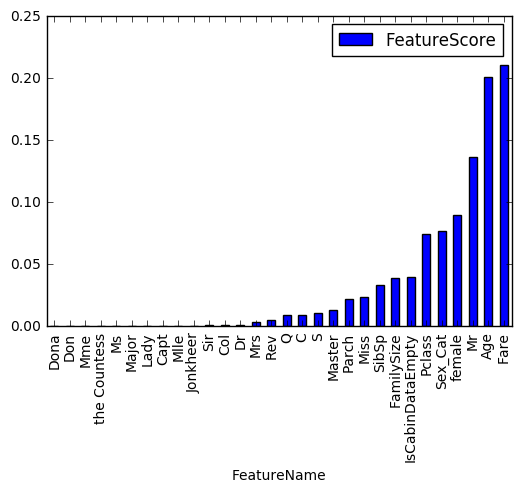

In [20]:
# Lets create the dataset that will be used for determining feature importance. 
featureNames = mergedTitanicDS_Merged_Red.ix[:,mergedTitanicDS_Merged_Red.columns.difference(['PassengerId','Survived'])].columns
Xtrain = mergedTitanicDS_Merged_Red[mergedTitanicDS_Merged_Red.Survived>=0].ix[:,mergedTitanicDS_Merged_Red.columns.difference(['PassengerId','Survived'])].values
ytrain = mergedTitanicDS_Merged_Red[mergedTitanicDS_Merged_Red.Survived>=0].ix[:,mergedTitanicDS_Merged_Red.columns == 'Survived'].values

Xtest = mergedTitanicDS_Merged_Red[mergedTitanicDS_Merged_Red.Survived<0].ix[:,mergedTitanicDS_Merged_Red.columns.difference(['PassengerId','Survived'])].values

# Tree-based feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris

from sklearn.feature_selection import *
clf = ExtraTreesClassifier()
clf = clf.fit(Xtrain, ytrain.ravel())

clf.feature_importances_
featureMatrixDS = pd.DataFrame({'FeatureName':featureNames.ravel(),'FeatureScore':clf.feature_importances_})
featureMatrixDS=featureMatrixDS.sort_values(by=['FeatureScore'])
featureMatrixDS.plot.bar('FeatureName','FeatureScore')

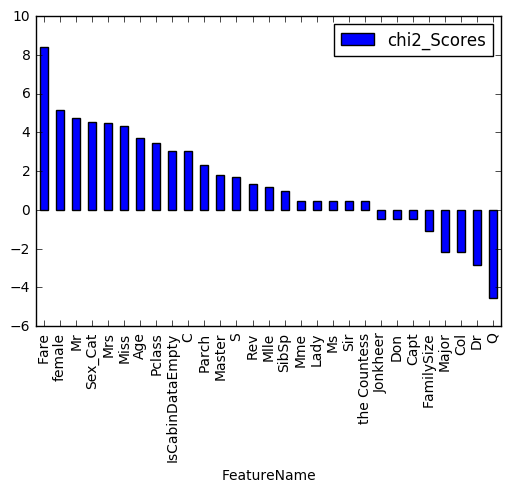

In [22]:
# Use the SelectKBest to run the chi square test
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import chi2

kBestSelector = SelectKBest(chi2, k='all')

Xtrain_Features = kBestSelector.fit(Xtrain,ytrain) 

featureMatrixDS_chi2 = pd.DataFrame({'FeatureName':featureNames,
                                     'chi2_pvalues':Xtrain_Features.pvalues_,
                                     'chi2_Scores':np.log(Xtrain_Features.scores_)})
featureMatrixDS_chi2_Sorted=featureMatrixDS_chi2.sort_values(by=['chi2_Scores'],ascending=False)
featureMatrixDS_chi2_Sorted[-featureMatrixDS_chi2_Sorted['chi2_Scores'].isnull()].plot.bar('FeatureName','chi2_Scores')

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000,max_features ="auto")

rf.fit(Xtrain, ytrain.ravel())
featureMatrixDS_randforest = pd.DataFrame({'FeatureName':featureNames.ravel(),'featureImportance':
                                           map(lambda x: round(x, 4), rf.feature_importances_)})
featureMatrixDS_randforest=featureMatrixDS_randforest.sort_values(by=['featureImportance'],ascending=False)
featureMatrixDS_randforest.plot.bar('FeatureName','featureImportance')

TypeError: object of type 'map' has no len()

In [27]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import *
from collections import defaultdict
  
scores = defaultdict(list)

# for ShuffleSplit takes the entire dataset of 891 data point runs the iteration 20 times and in each iteration it gives 30% of the data point as a test
for train_idx, test_idx in ShuffleSplit(len(Xtrain), 20, .3):
    X_train, X_test = Xtrain[train_idx], Xtrain[test_idx]
    Y_train, Y_test = ytrain[train_idx], ytrain[test_idx]
# The model is trained on the training dataset and the model performance is calculated using the f1_score
    r = rf.fit(X_train, Y_train.ravel())
    acc = f1_score(Y_test, rf.predict(X_test))
# The below loop is repeated across each of the features in X and in each iteration the each of the feature values are randomly 
# shuffled and the predict against the shuffled dataset. The model performance is measured against each features change.
    for i in range(Xtrain.shape[1]):      
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = f1_score(Y_test, rf.predict(X_t))
        scores[featureNames[i]].append((acc-shuff_acc)/acc)
# At the end of the process, an array of features and its corresponding effect on the model is recorded.
# A mean of the effect across the features relays the importance of the feature
print("Features sorted by their score:")
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

featureMatrixDS_rf_mda = pd.DataFrame(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))
featureMatrixDS_rf_mda.columns = ['FeatureEffect','FeatureName']
featureMatrixDS_rf_mda.plot.bar('FeatureName','FeatureEffect')

KeyboardInterrupt: 

In [ ]:
featureMatrixDS_rf_mda[featureMatrixDS_rf_mda['FeatureEffect']!=0].plot.bar('FeatureName','FeatureEffect')